In [939]:
# To increase the size of the cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))  # To change the cell size

# Project: Janatahack: Customer Segmentation

An automobile company has plans to enter new markets with their existing products (P1, P2, P3, P4 and P5). After intensive market research, they’ve deduced that the behavior of new market is similar to their existing market. 

In their existing market, the sales team has classified all customers into 4 segments (A, B, C, D ). Then, they performed segmented outreach and communication for different segment of customers. This strategy has work exceptionally well for them. They plan to use the same strategy on new markets and have identified 2627 new potential customers. 

You are required to help the manager to predict the right group of the new customers.

## Importing Packages

In [940]:
import pandas as pd
import os

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Setting Display size
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 300)

import missingno as msno # For visualizing missing values
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
from impyute.imputation.cs import mice

## Importing Dataset

In [941]:
print('Current working Directory',os.getcwd())#Find out your current working directory
root = 'D:\\PrivateProjects\Customer_segmentation'
os.chdir(root)
print('Changed Working Directory',os.getcwd())#Find out your (changed) current working directory

Current working Directory D:\PrivateProjects\Customer_segmentation
Changed Working Directory D:\PrivateProjects\Customer_segmentation


### Importing data - train, test, sample_submission

In [942]:
df_train = pd.read_csv(f'{root}\data\Train_aBjfeNk.csv')
df_test = pd.read_csv(f'{root}\data\Test_LqhgPWU.csv')
df_submission = pd.read_csv(f'{root}\data\sample_submission_wyi0h0z.csv')

In [943]:
print('We have {} rows & {} columns in training dataset'.format(df_train.shape[0],df_train.shape[1] ))
print('We have {} rows & {} columns in testing dataset'.format(df_test.shape[0],df_train.shape[1]))
print('We have {} rows & {} columns in sample submission dataset'.format(df_submission.shape[0],df_train.shape[1]))

We have 8068 rows & 11 columns in training dataset
We have 2627 rows & 11 columns in testing dataset
We have 2627 rows & 11 columns in sample submission dataset


In [944]:
#To get over all idea about the columns in dataset like count of unique values, type, % of missing values

def describe_df(df):
    stats = []
    for col in df.columns:
        stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))
    
    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
    stats_df.sort_values('Percentage of missing values', ascending=False)
    return stats_df

In [945]:
describe_df(df_train)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
0,ID,8068,0.000000,0.012395,int64
1,Gender,2,0.000000,54.747149,object
2,Ever_Married,2,1.735250,57.548339,object
3,Age,67,0.000000,3.098661,int64
4,Graduated,2,0.966782,61.576599,object
5,Profession,9,1.536936,31.184928,object
6,Work_Experience,15,10.275161,29.176996,float64
7,Spending_Score,3,0.000000,60.461081,object
8,Family_Size,9,4.152206,29.623203,float64
9,Var_1,7,0.941993,64.923153,object


In [946]:
# %matplotlib inline
# # %matplotlib notebook
# msno.matrix(df_train,labels = True,figsize=(50, 10))

In [947]:
describe_df(df_test)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
0,ID,2627,0.000000,0.038066,int64
1,Gender,2,0.000000,54.206319,object
2,Ever_Married,2,1.903312,57.860678,object
3,Age,67,0.000000,3.349829,int64
4,Graduated,2,0.913590,60.982109,object
5,Profession,9,1.446517,30.529121,object
6,Work_Experience,15,10.239817,29.425200,float64
7,Spending_Score,3,0.000000,61.515036,object
8,Family_Size,9,4.301485,29.234869,float64
9,Var_1,7,1.218120,63.646745,object


In [948]:
# %matplotlib inline
# # %matplotlib notebook
# msno.matrix(df_test,labels = True,figsize=(50, 10))

 - Let's combaine train & test, then remove the rows with missing columns.
 - Save the rows with the missing columns for later use.
 - Do teh data processing with the remaining rows.

In [949]:
df_train['is_train'] = '1'
df_test['is_train'] = '0'
df_full = pd.concat([df_train, df_test])

In [950]:
df_full['is_train'] = df_full['is_train'].astype('int64')

### Predictive score

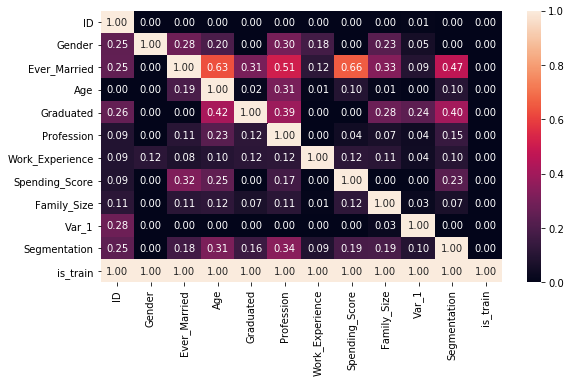

In [951]:
%matplotlib inline
plt.figure(figsize=(9,5))
sns.heatmap(pps.matrix(df_train),annot=True,fmt=".2f")

###### Insights:
            - Age has 63% correlation with Ever_Married
            - Profession has 51% good scorre with Ever_married
            - ding_Score has 66% good score with Ever_married
            - Segmentaion depends on Spending_Score, Graduated, Ever_Married
            - Its is important to fill missing values of  Ever_Married,Graduated,Profession in that order

 - How distribuded the segments are?


In [952]:
df_train.Segmentation.value_counts()/df_train.shape[0]

D    0.281111
A    0.244422
C    0.244175
B    0.230293
Name: Segmentation, dtype: float64

Answer : We can see the segments are almost equally distributed, no need to worry about sampling issues

#### Data Processing

Info:

    Binary columns : {Ever_Married, Gender, Graduated}
    Ordinal column : {Spending_Score}
    Nominal column : {Profession,Var_1, Segmentation}
    numerical column : {Age, Work_experience, Family_Size}
    id column : {ID}

In [953]:
# Create df with ID & Segment
df_id_segment = df_full[['ID','Segmentation','is_train']]

In [954]:
df_full.drop('Segmentation',axis = 1,inplace = True) # Dropping target

In [955]:
df_full.fillna('NA',inplace = True)

In [956]:
#Processing Binary Columns

gender = {'Male': 1,'Female': 0}
df_full.Gender = [gender[item] for item in df_full.Gender]

graduate = {'Yes': 1,'No': 0, 'NA':'NA'}
df_full.Graduated = [graduate[item] for item in df_full.Graduated]

ever_married = {'Yes': 1,'No': 0, 'NA':'NA'}
df_full.Ever_Married = [ever_married[item] for item in df_full.Ever_Married]

In [957]:
# Processing Ordinal column
score = {'Low' : 1 , 'Average' : 2, 'High' : 3}
df_full.Spending_Score = [score[item] for item in df_full.Spending_Score]

#### Handle Missing values

In [958]:
df_full.replace('NA', np.nan,inplace = True)

In [959]:
df_full_dummies = pd.get_dummies(df_full[['Age', 'Ever_Married', 'Family_Size', 'Gender', 'Graduated','ID',
       'Profession', 'Spending_Score', 'Var_1','Work_Experience', 'is_train']])

#### MICE - Missing Values

In [960]:
# start the MICE training
imputed_training_mice=mice(df_full_dummies.values)
imputed_training_mice = pd.DataFrame(imputed_training_mice)

cols = df_full_dummies.columns # Since imputed_training is numpy array wer have to convert it to PD dataframe & assign col names
imputed_training_mice.columns = cols

In [961]:
imputed_training_mice[['ID','is_train']] = imputed_training_mice[['ID','is_train']].astype('int64')

In [962]:
df_processed_mice = pd.merge(imputed_training_mice,df_id_segment, how = 'inner', on =['ID','is_train'])

#### KNN

In [963]:
import sys
from impyute.imputation.cs import fast_knn
sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

# start the KNN training
imputed_training_knn =fast_knn(df_full_dummies.values, k=30)
imputed_training_knn = pd.DataFrame(imputed_training_knn)

cols = df_full_dummies.columns # Since imputed_training is numpy array wer have to convert it to PD dataframe & assign col names
imputed_training_knn.columns = cols

In [964]:
imputed_training_knn[['ID','is_train']] = imputed_training_knn[['ID','is_train']].astype('int64')
df_processed_knn = pd.merge(imputed_training_knn,df_id_segment, how = 'inner', on =['ID','is_train'])

###### Now that we have imputed the missing values we can combain these two imputations & take average

List of cols with missing values : 
    - Ever_Married
    - Graduated
    - Profession
    - Work_Experience
    - Family_Size
    - var_1

In [965]:
temp = pd.concat((df_processed_knn, df_processed_mice)); 
df_final = temp.groupby(temp.index).mean()

In [966]:
df_final = pd.merge(df_final, df_id_segment, how = 'inner', on =['ID','is_train'] )

In [967]:
Segmentation = df_final[['ID','Segmentation','is_train']]

In [968]:
df_final.drop(['Segmentation','ID','is_train'],axis = 1, inplace = True)

In [969]:
from sklearn import preprocessing
col = df_final.columns
df_final = preprocessing.scale(df_final)

In [970]:
df_final = pd.DataFrame(df_final)
df_final.columns = col

In [972]:
df_final = pd.concat([df_final,Segmentation], axis = 1)

In [ ]:
df_final.head()

In [974]:
df_final_train = df_final[df_final['is_train'] == 1]
df_final_test = df_final[df_final['is_train'] == 0]

In [975]:
df_final_train.drop(['is_train'],axis = 1,inplace = True)
df_final_test.drop(['is_train'],axis = 1,inplace = True)

In [976]:
df_final_train.to_csv('train.csv',index = False)
df_final_test.to_csv('test.csv',index = False)

##### Let's see hwo the Segment is distributed in training df

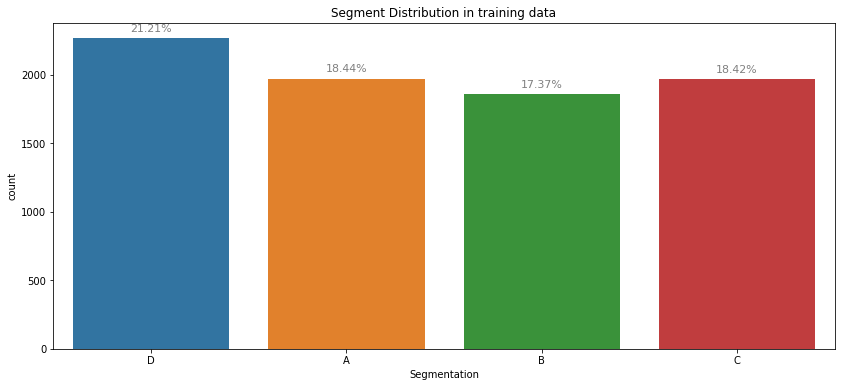

In [977]:
plt.figure(figsize=(14, 6));
g = sns.countplot(x='Segmentation', data=df_final_train)
plt.title('Segment Distribution in training data');
ax=g.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / df_processed.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points')

### Model - MLP

In [978]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [979]:
df_final_train.drop('ID', axis = 1, inplace = True)

In [980]:
y = df_final_train['Segmentation']
x = df_final_train.drop(['Segmentation'], axis=1)

In [981]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.10, random_state=27)

In [821]:
clf = MLPClassifier(hidden_layer_sizes=(500,500,500,500,500,500,500), max_iter=1000, alpha=0.0001,
                     solver='adam', verbose=10,  random_state=21,tol=0.000000001, activation= 'relu' )

In [822]:
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

Iteration 1, loss = 1.35640212
Iteration 2, loss = 1.25848912
Iteration 3, loss = 1.18898097
Iteration 4, loss = 1.14372614
Iteration 5, loss = 1.11813820
Iteration 6, loss = 1.13337760
Iteration 7, loss = 1.09514002
Iteration 8, loss = 1.09161690
Iteration 9, loss = 1.07883930
Iteration 10, loss = 1.09022837
Iteration 11, loss = 1.09849439
Iteration 12, loss = 1.10683469
Iteration 13, loss = 1.07546119
Iteration 14, loss = 1.07555953
Iteration 15, loss = 1.07547945
Iteration 16, loss = 1.07788581
Iteration 17, loss = 1.06998498
Iteration 18, loss = 1.06230138
Iteration 19, loss = 1.06983876
Iteration 20, loss = 1.08098681
Iteration 21, loss = 1.07057107
Iteration 22, loss = 1.05931670
Iteration 23, loss = 1.04946181
Iteration 24, loss = 1.05315975
Iteration 25, loss = 1.04379675
Iteration 26, loss = 1.04931369
Iteration 27, loss = 1.05656928
Iteration 28, loss = 1.04450955
Iteration 29, loss = 1.05331141
Iteration 30, loss = 1.06607874
Iteration 31, loss = 1.03519897
Iteration 32, los

In [798]:
accuracy_score(y_test, y_pred) #0.519087754090233, 0.5161130391670798, 0.5176003966286564,0.4969021065675341,0.44981412639405205,0.459727385377943

0.4634448574969021

In [782]:
temp = pd.DataFrame(y_pred == y_test).astype('int')
y_test = pd.DataFrame(y_test)
y_test['Succuss'] = temp

In [783]:
y_test.groupby('Segmentation')['Succuss'].sum()/y_test.groupby('Segmentation')['Segmentation'].count()

Segmentation
A    0.360215
B    0.343915
C    0.497462
D    0.612766
dtype: float64

### ONE VS REST

In [982]:
from sklearn.linear_model import LogisticRegression
logregressor = LogisticRegression(solver="liblinear", multi_class="ovr")

In [983]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.10, random_state=27)

In [984]:
train_y = y_train.as_matrix()  # To get the right vector-like shape call as_matrix on the single column
train_X = x_train.as_matrix()

logregressor.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [985]:
y_pred = logregressor.predict(x_test)

In [986]:
accuracy_score(y_test, y_pred) #0.519087754090233, 0.5161130391670798, 0.5176003966286564,0.4969021065675341,0.44981412639405205,0.459727385377943

0.5092936802973977

In [987]:
temp = pd.DataFrame(y_pred == y_test).astype('int')
y_test = pd.DataFrame(y_test)
y_test['Succuss'] = temp

In [988]:
y_test.groupby('Segmentation')['Succuss'].sum()/y_test.groupby('Segmentation')['Segmentation'].count()

Segmentation
A    0.467742
B    0.158730
C    0.639594
D    0.714894
dtype: float64

### Ensemble Classifier

In [989]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

In [990]:
# # Swiss army knife function to organize the data

# def encode(df_final_train, df_final_test):
#     le = LabelEncoder().fit(df_final_train['Segmentation']) 
#     labels = le.transform(df_final_train['Segmentation'])           # encode species strings
#     classes = list(le.classes_)                    # save column names for submission
#     test_ids = df_final_test.ID                             # save test ids for submission
    
      
#     df_final_test = df_final_test.drop(['ID'], axis=1)
    
#     return df_final_train, labels, df_final_test, test_ids, classes

# train, labels, test, test_ids, classes = encode(df_final_train, df_final_test)
# train.head(1)

In [991]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.10, random_state=27)

In [992]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

classifiers = [
    LogisticRegression(random_state=1),
    DecisionTreeClassifier(),
    KNeighborsClassifier(4),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    MLPClassifier(hidden_layer_sizes=(500,500,500,100,100,100,100,100,100), max_iter=1000, alpha=0.0001,
                     solver='adam', verbose=10,  random_state=21,tol=0.000000001, activation= 'relu' )
]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(x_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(x_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(x_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

LogisticRegression
****Results****
Accuracy: 50.5576%
Log Loss: 1.116240827905893
DecisionTreeClassifier
****Results****
Accuracy: 43.8662%
Log Loss: 18.937341884523384
KNeighborsClassifier
****Results****
Accuracy: 48.4511%
Log Loss: 7.231026478818772
SVC
****Results****
Accuracy: 46.7162%
Log Loss: 1.1441846768134245
NuSVC
****Results****
Accuracy: 53.5316%
Log Loss: 1.1030755610655756
RandomForestClassifier
****Results****
Accuracy: 49.0706%
Log Loss: 1.8155425601674826
AdaBoostClassifier
****Results****
Accuracy: 51.1772%
Log Loss: 1.3711869257909686
GradientBoostingClassifier
****Results****
Accuracy: 54.8947%
Log Loss: 1.0299283465196714
GaussianNB
****Results****
Accuracy: 44.3618%
Log Loss: 2.5710605766152965
LinearDiscriminantAnalysis
****Results****
Accuracy: 51.0533%
Log Loss: 1.1340086295821639
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 46.8401%
Log Loss: 2.415214979634928
Iteration 1, loss = 1.19720323
Iteration 2, loss = 1.09952415
Iteration 3, loss = 1.06886

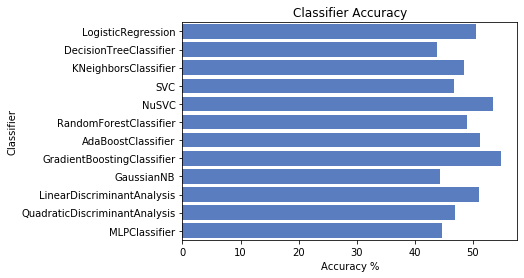

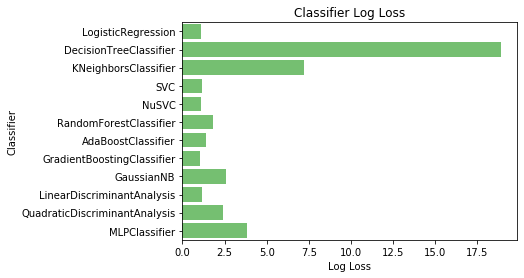

In [994]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

In [996]:
from sklearn.ensemble import VotingClassifier

model1 = LogisticRegression(random_state=1)
# model2 = DecisionTreeClassifier(random_state=1)
model3 = KNeighborsClassifier(4)
# model4 = SVC(kernel="rbf", C=0.025, probability=True)
model5 = NuSVC(probability=True)
model6 = RandomForestClassifier()
model7 = AdaBoostClassifier()
model8 = GradientBoostingClassifier()
# model9 = GaussianNB()
model10 = LinearDiscriminantAnalysis()
# model11 = QuadraticDiscriminantAnalysis()
# model12 = MLPClassifier(hidden_layer_sizes=(500,500,500,100,100,100,100,100,100), max_iter=1000, alpha=0.0001,
#                      solver='adam', verbose=10,  random_state=21,tol=0.000000001, activation= 'relu' )


model = VotingClassifier(estimators=[('lr', model1),
#                                      ('dtc', model2),
                                      ('knc', model3),
#                                      ('svc', model4),
                                      ('nsv', model5),
                                      ('rfc', model6),
                                      ('abc', model7),
                                      ('gbc', model8),
#                                      ('gnb', model9),
                                      ('lda', model10),
#                                      ('qda', model11),
#                                      ('mlp',model12)
                                    
                                    ],
                                     voting='hard')
model.fit(x_train, y_train)
model.score( x_test, y_test)

0.5539033457249071

In [997]:
col = x_train.columns

In [998]:
temp = df_final_test[col]

In [999]:
pred = model.predict(temp)

In [1000]:
pd.DataFrame(pred).to_csv('submission_ensmbl.csv',index = False)